# Exoplanets

In [1]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

# Sklearn Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, precision_score, confusion_matrix, accuracy_score

# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

An exoplanet is a planet that orbits a star outside our solar system. Some exoplanets don't orbit stars but rather some galactic center, these are called "rogue planets". This data doesn't have any information on "rogue" planets.

The dataset I'll be using is from Caltech and NASA, collected from the Kepler missions. The data consists of KOI's, or Kepler Objects of Interest. There are several columns, one of which being the status of a certain KOI being an exoplanet, with values Candidate, Confirmed, or False Positive. We will use this data to train a model to predict a KOI's likelihood of being an exoplanet.

## Data Exploration

### Data Cleaning

In [2]:
planet = pd.read_csv("nasa_exo_2022.csv")

In [3]:
planet.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


Let's rename some columns, the dataset came with a more descriptive column naming scheme so were just gonna use that, and condense some of the names

In [4]:
planet = planet.rename(columns={
'koi_disposition':'archiveDisposition',
'koi_pdisposition':'DispositionUsingKeplerData',
'koi_score':'DispositionScore',
'koi_fpflag_nt':'NotTransit-LikeFalsePositiveFlag',
'koi_fpflag_co':'CentroidOffsetFalsePositiveFlag',
'koi_fpflag_ec':'EphemerisMatchIndicatesContaminationFalsePositiveFlag',
'koi_period':'OrbitalPeriod(days)',
'koi_period_err1':'OrbitalPeriodUpperUnc(days)',
'koi_period_err2':'OrbitalPeriodLowerUnc(days)',
'koi_time0bk':'TransitEpoch(BKJD)',
'koi_time0bk_err1':'TransitEpochUpperUnc(BKJD)',
'koi_time0bk_err2':'TransitEpochLowerUnc(BKJD)',
'koi_impact':'ImpactParameter',
'koi_impact_err1':'ImpactParameterUpperUnc',
'koi_impact_err2':'ImpactParameterLowerUnc',
'koi_duration':'TransitDuration(hrs)',
'koi_duration_err1':'TransitDurationUpperUnc(hrs)',
'koi_duration_err2':'TransitDurationLowerUnc(hrs)',
'koi_depth':'TransitDepth(ppm)',
'koi_depth_err1':'TransitDepthUpperUnc(ppm)',
'koi_depth_err2':'TransitDepthLowerUnc(ppm)',
'koi_prad':'PlanetaryRadius(Earthradii)',
'koi_prad_err1':'PlanetaryRadiusUpperUnc(Earthradii)',
'koi_prad_err2':'PlanetaryRadiusLowerUnc(Earthradii)',
'koi_teq':'EquilibriumTemperature(K)',
'koi_teq_err1':'EquilibriumTemperatureUpperUnc(K)',
'koi_teq_err2':'EquilibriumTemperatureLowerUnc(K)',
'koi_insol':'InsolationFlux(Earthflux)',
'koi_insol_err1':'InsolationFluxUpperUnc(Earthflux)',
'koi_insol_err2':'InsolationFluxLowerUnc(Earthflux)',
'koi_model_snr':'TransitSignal-to-Nois',
'koi_tce_plnt_num':'TCEPlanetNumber',
'koi_tce_delivname':'TCEDeliver',
'koi_steff':'EffectiveTemperature(K)',
'koi_steff_err1':'EffectiveTemperatureUpperUnc(K)',
'koi_steff_err2':'EffectiveTemperatureLowerUnc(K)',
'koi_slogg':'SurfaceGravity(log10(cm/s**2))',
'koi_slogg_err1':'SurfaceGravityUpperUnc(log10(cm/s**2))',
'koi_slogg_err2':'SurfaceGravityLowerUnc(log10(cm/s**2))',
'koi_srad':'Radius(Solarradii)',
'koi_srad_err1':'RadiusUpperUnc(Solarradii)',
'koi_srad_err2':'RadiusLowerUnc(Solarradii)',
'ra':'RA(decimaldegrees)',
'dec':'Dec(decimaldegrees)',
'koi_kepmag':'Kepler-band(mag)'
})

Full disclosure, I am not an astronomer, I just think space is cool. I need to define somethings for my own sake.
- Unc means uncertainty, most measures have uncertainty upper and lower bounds, so perhaps we can incorporate this in some way.
- BKJD is the Barycentric Kepler Julian Date which is the Julian Date (JD) corrected for differences in the Earth's position with respect to the barycentre of the Solar System.
    - The Julian Date is very simple, Jan 1st is the number 001, and december 31st is the number 365, July 29th(my birthday) is 210.
    - The barycentre of the Solar System is the center of mass of every object in the solar system combined. Our solar system's barycenter constantly changes position. Its position depends on where the planets are in their orbits. The solar system's barycenter can range from being near the center of the sun to being outside the surface of the sun.
- Solar Radius - Solar radius is a unit of distance used to express the size of stars in astronomy relative to the Sun. The solar radius is usually defined as the radius to the layer in the Sun's photosphere. 1 solar radius = 6.957 * 10^8 meters
- Earth flux, I couldn't find too much on this one but, solar flux just outside Earth's atmosphere is referred to as the “solar constant” and has a value of approximately 1373 W m− 2, where solar flux is a measure of how much light energy is being radiated in a given area.

You learn something new everyday!

In [5]:
planet["DispositionUsingKeplerData"].value_counts()

FALSE POSITIVE    4847
CANDIDATE         4717
Name: DispositionUsingKeplerData, dtype: int64

In [6]:
planet["PossibleExoplanet"] = planet["DispositionUsingKeplerData"].apply(lambda x : 1 if x == 'CANDIDATE' else 0)

In [7]:
planet["archiveDisposition"].value_counts()

FALSE POSITIVE    4839
CONFIRMED         2668
CANDIDATE         2057
Name: archiveDisposition, dtype: int64

In [8]:
planet["ConfirmedExoplanet"] = planet["archiveDisposition"].apply(lambda x: 2 if x == 'CONFIRMED' else 1 if x == 'CANDIDATE' else 0 )

In [9]:
planet.head()

,kepid,kepoi_name,kepler_name,archiveDisposition,DispositionUsingKeplerData,DispositionScore,NotTransit-LikeFalsePositiveFlag,koi_fpflag_ss,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,...,SurfaceGravityUpperUnc(log10(cm/s**2)),SurfaceGravityLowerUnc(log10(cm/s**2)),Radius(Solarradii),RadiusUpperUnc(Solarradii),RadiusLowerUnc(Solarradii),RA(decimaldegrees),Dec(decimaldegrees),Kepler-band(mag),PossibleExoplanet,ConfirmedExoplanet
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,1,2
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,1,2
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436,1,1
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597,0,0
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,1,2


In [10]:
planet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 51 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   kepid                                                  9564 non-null   int64  
 1   kepoi_name                                             9564 non-null   object 
 2   kepler_name                                            2670 non-null   object 
 3   archiveDisposition                                     9564 non-null   object 
 4   DispositionUsingKeplerData                             9564 non-null   object 
 5   DispositionScore                                       8054 non-null   float64
 6   NotTransit-LikeFalsePositiveFlag                       9564 non-null   int64  
 7   koi_fpflag_ss                                          9564 non-null   int64  
 8   CentroidOffsetFalsePositiveFlag                 

We can definitely drop some of these columns. Some have no info, lots of missing info, or just info we aren't going to use, such as the flags that are categorical and are hard to find the meaning of.

In [11]:
planet = planet.drop(['kepler_name','kepoi_name','archiveDisposition','DispositionUsingKeplerData',
                 'NotTransit-LikeFalsePositiveFlag','koi_fpflag_ss','CentroidOffsetFalsePositiveFlag',
                 'EphemerisMatchIndicatesContaminationFalsePositiveFlag','TCEDeliver'], axis = 1)

We also need to drop the column Disposition Score, because it is determined AFTER the flag of CANDIDATE or FALSE POSITIVE is given, as it is a score of confidence in that classification. I solely want to use the data about the planet, such as its temp, radius, etc.

I will also drop uncertainty values, as they are just error measurements on the actual values we want. For now we will ignore them.

In [12]:
planet = planet.drop(["DispositionScore", 'PlanetaryRadiusUpperUnc(Earthradii)','EquilibriumTemperatureUpperUnc(K)',
'EquilibriumTemperatureLowerUnc(K)','PlanetaryRadiusLowerUnc(Earthradii)', 'InsolationFluxUpperUnc(Earthflux)','InsolationFluxLowerUnc(Earthflux)',
'EffectiveTemperatureUpperUnc(K)', 'EffectiveTemperatureLowerUnc(K)', 'SurfaceGravityUpperUnc(log10(cm/s**2))',
'SurfaceGravityLowerUnc(log10(cm/s**2))','RadiusUpperUnc(Solarradii)', 'RadiusLowerUnc(Solarradii)','OrbitalPeriodUpperUnc(days)', 
'OrbitalPeriodLowerUnc(days)','TransitEpochUpperUnc(BKJD)','TransitEpochLowerUnc(BKJD)','ImpactParameterUpperUnc', 'ImpactParameterLowerUnc',
'TransitDurationUpperUnc(hrs)','TransitDurationLowerUnc(hrs)','TransitDepthUpperUnc(ppm)', 'TransitDepthLowerUnc(ppm)'], axis = 1)

In [13]:
planet.isna().any()

kepid                             False
OrbitalPeriod(days)               False
TransitEpoch(BKJD)                False
ImpactParameter                    True
TransitDuration(hrs)              False
TransitDepth(ppm)                  True
PlanetaryRadius(Earthradii)        True
EquilibriumTemperature(K)          True
InsolationFlux(Earthflux)          True
TransitSignal-to-Nois              True
TCEPlanetNumber                    True
EffectiveTemperature(K)            True
SurfaceGravity(log10(cm/s**2))     True
Radius(Solarradii)                 True
RA(decimaldegrees)                False
Dec(decimaldegrees)               False
Kepler-band(mag)                   True
PossibleExoplanet                 False
ConfirmedExoplanet                False
dtype: bool

We can't have any na values, perhaps I can revisit going column by column and doing some column-wise data cleaning, but for now I think its safe to drop all the na values. I would assume exoplanets have many different features so averaging columns for example wouldn't be the best option.

In [14]:
planet = planet.dropna()

In [15]:
planet.shape

(8945, 19)

Were left with 7803 observations and 40 predictors, that's pretty good!

### Data Viz

(array([7094.,  856.,  433.,  198.,   97.,   65.,   39.,   17.,   14.,
          10.]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 <BarContainer object of 10 artists>)

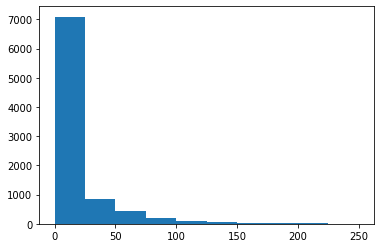

In [16]:
plt.hist(planet["PlanetaryRadius(Earthradii)"], range = [0,250])

I had to zoom in many times to get to this level, and its pretty clear that a lot of the objects are really small, and only a small number of them are quite large.

(array([2.649e+03, 6.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 <BarContainer object of 10 artists>)

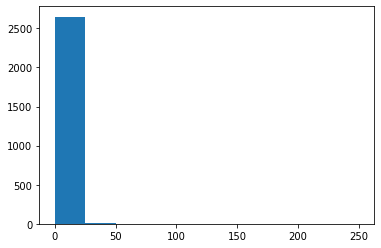

In [17]:
plt.hist(planet[planet["ConfirmedExoplanet"] == 2]["PlanetaryRadius(Earthradii)"], range = [0,250])

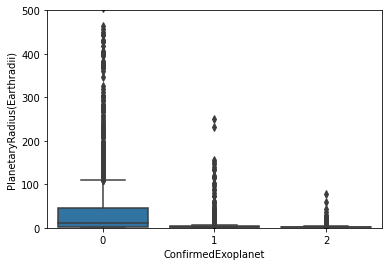

In [18]:
sns.boxplot(x="ConfirmedExoplanet", y="PlanetaryRadius(Earthradii)", data = planet)
plt.ylim(0, 500)
plt.show()

Even the confirmed exoplanets are quite small, actually the smallest of all the objects.

(array([   8.,   15.,   10.,   10.,   84.,  151.,  409., 2103., 6076.,
          79.]),
 array([0.047 , 0.5787, 1.1104, 1.6421, 2.1738, 2.7055, 3.2372, 3.7689,
        4.3006, 4.8323, 5.364 ]),
 <BarContainer object of 10 artists>)

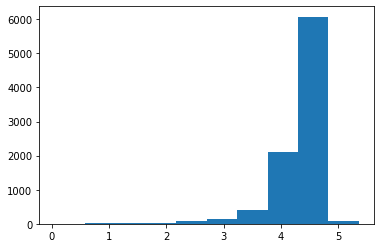

In [19]:
plt.hist(planet["SurfaceGravity(log10(cm/s**2))"])

<AxesSubplot:xlabel='ConfirmedExoplanet', ylabel='TransitDuration(hrs)'>

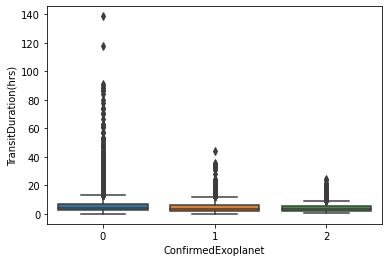

In [20]:
sns.boxplot(x="ConfirmedExoplanet", y="TransitDuration(hrs)", data = planet)

(0.0, 100000.0)

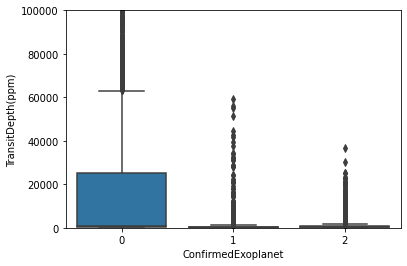

In [21]:

sns.boxplot(x="ConfirmedExoplanet", y="TransitDepth(ppm)", data = planet)
plt.ylim(0, 100000)


The transit depth is "the fraction of stellar flux lost at the minimum of the planetary transit", so essentially how bright/dim the light from a star became after the planet passed in front of it.

It seems this is much more concentrated in lower ppm for confirmed and candidate exoplanets than the false positive ones, which have a huge range. This will likely be a main predictor in the model.

(0.0, 8000.0)

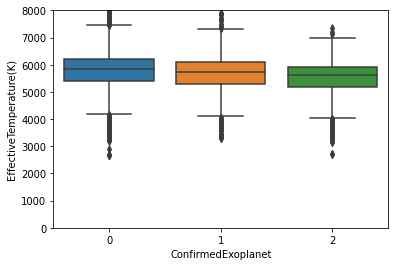

In [22]:
sns.boxplot(x="ConfirmedExoplanet", y="EffectiveTemperature(K)", data = planet)
plt.ylim(0,8000)

Temperature doesn't really seem to have an effect, the mean for all the KOIs are about the same.

## Classification

In [23]:
def evaluation(y_test, y_pred):
    
    # Print Accuracy, Recall, F1 Score, and Precision metrics.
    print('Evaluation:')
    print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
    print('Recall: ' + str(metrics.recall_score(y_test, y_pred)))
    print('F1 Score: ' + str(metrics.f1_score(y_test, y_pred)))
    print('Precision: ' + str(metrics.precision_score(y_test, y_pred)))
    
    # Print Confusion Matrix
    print('\nConfusion Matrix:')
    print(' TN,  FP, FN, TP')
    print(confusion_matrix(y_test, y_pred).ravel())
    
# Function Prints best parameters for GridSearchCV
def print_results(results):
    print('Best Parameters: {}\n'.format(results.best_params_)) 

In [24]:
planet

,kepid,OrbitalPeriod(days),TransitEpoch(BKJD),ImpactParameter,TransitDuration(hrs),TransitDepth(ppm),PlanetaryRadius(Earthradii),EquilibriumTemperature(K),InsolationFlux(Earthflux),TransitSignal-to-Nois,TCEPlanetNumber,EffectiveTemperature(K),SurfaceGravity(log10(cm/s**2)),Radius(Solarradii),RA(decimaldegrees),Dec(decimaldegrees),Kepler-band(mag),PossibleExoplanet,ConfirmedExoplanet
0,10797460,9.488036,170.538750,0.146,2.95750,616.0,2.26,793.0,93.59,35.8,1.0,5455.0,4.467,0.927,291.93423,48.141651,15.347,1,2
1,10797460,54.418383,162.513840,0.586,4.50700,875.0,2.83,443.0,9.11,25.8,2.0,5455.0,4.467,0.927,291.93423,48.141651,15.347,1,2
2,10811496,19.899140,175.850252,0.969,1.78220,10800.0,14.60,638.0,39.30,76.3,1.0,5853.0,4.544,0.868,297.00482,48.134129,15.436,1,1
3,10848459,1.736952,170.307565,1.276,2.40641,8080.0,33.46,1395.0,891.96,505.6,1.0,5805.0,4.564,0.791,285.53461,48.285210,15.597,0,0
4,10854555,2.525592,171.595550,0.701,1.65450,603.0,2.75,1406.0,926.16,40.9,1.0,6031.0,4.438,1.046,288.75488,48.226200,15.509,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151,0.527699,131.705093,1.252,3.22210,1580.0,29.35,2088.0,4500.53,453.3,1.0,5638.0,4.529,0.903,297.18875,47.093819,14.082,0,0
9560,10128825,1.739849,133.001270,0.043,3.11400,48.5,0.72,1608.0,1585.81,10.6,1.0,6119.0,4.444,1.031,286.50937,47.163219,14.757,1,1
9561,10147276,0.681402,132.181750,0.147,0.86500,104.0,1.07,2218.0,5713.41,12.3,1.0,6173.0,4.447,1.041,294.16489,47.176281,15.385,0,0
9562,10155286,333.486169,153.615010,0.214,3.19900,639.0,19.30,557.0,22.68,14.0,1.0,4989.0,2.992,7.824,296.76288,47.145142,10.998,1,1


In [25]:
planet = planet.drop(columns = ["kepid"])

In [26]:
predictors = planet.drop(columns=['PossibleExoplanet','ConfirmedExoplanet'])
y = planet["PossibleExoplanet"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(predictors, y, random_state=1, test_size=0.30)

In [28]:
scaler_tr = preprocessing.StandardScaler().fit(X_train)
scaler_ts = preprocessing.StandardScaler().fit(X_test)
X_tr_scaled = scaler_tr.transform(X_train)
X_tst_scaled = scaler_ts.transform(X_test)

### Logistic Regression

Logistice Regression is a very simple classification method. The model takes the form of 
$$p(x) = \frac{1}{1+ e^{\beta_0 + \beta_1x}}$$ where $$\beta_0$$ is the intercept, and $$\beta_1$$ is the slope of the log odds function as a function of x. The result is: ![logistic graph](images/log.jpeg)
As we can see, the points are fit into two classes, and compared to linear regression, the fit of f(x) is much tighter. The value $$\mu$$ is the boundary where the the classes are split. If we rewrite the equation above we get : $$p(x) = \frac{1}{1+ e^{-(x - \mu)/s}}$$ where s is a scaling parameter, basically, the larger value of s, the more spread out the distribution is.


I will start with a simple logistic regression, as a baseline. The parameters I will use are:
- C : This is the inverse of regularization strength. It will essentially reduce overfitting by penalizing larger values of the parameters. Large values will contribute less to the fit of the model and therefore reduce overfitting.
- max_iter : This is the max iterations used for the solvers to converge
- class_weight : from sklearn: The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

In [29]:
# Logistic Regression Model
lr = LogisticRegression(C=100, max_iter=400, class_weight='balanced')

# Fitting Model to the train set
lr.fit(X_train, y_train)

# Predicting on the test set
y_pred = lr.predict(X_test)

# Evaluating model
evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.763785394932936
Recall: 0.8663220088626292
F1 Score: 0.7872483221476511
Precision: 0.7214022140221402

Confusion Matrix:
 TN,  FP, FN, TP
[ 877  453  181 1173]
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Let's try using the scaled data.

In [30]:
# Logistic Regression Model
lr = LogisticRegression(C=100, max_iter=400, class_weight='balanced')

# Fitting Model to the train set
lr.fit(X_tr_scaled, y_train)

# Predicting on the test set
y_pred = lr.predict(X_tst_scaled)

# Evaluating model
evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.7932190760059612
Recall: 0.8788774002954209
F1 Score: 0.8109028960817717
Precision: 0.7526881720430108

Confusion Matrix:
 TN,  FP, FN, TP
[ 939  391  164 1190]


### KNN

K Nearest Neighbors essentially looks at each data points K nearest points, and uses their classification. The parameters I will use:
- n_neighbors : How many neighbors should be used for each point.
- metric : There are several different metrics to use for distance calculations, and hence finding the closest points. Examples : 'manhattan', 'cosine', 'minkowski'
- weights : There are different methods of determining weights of each point in a neighborhood. Uniform gives all the points equal weight whereas distance will give more weight to closer points in the neighborhood.

In [31]:
knn = KNeighborsClassifier(n_neighbors = 5, metric='manhattan',weights='uniform')

# Fitting Model to the train set
knn.fit(X_train, y_train)

# Predicting on the test set
y_pred = knn.predict(X_test)

# Evaluating model
evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.7522354694485842
Recall: 0.8131462333825702
F1 Score: 0.7680502267178235
Precision: 0.7276933245208196

Confusion Matrix:
 TN,  FP, FN, TP
[ 918  412  253 1101]


In [32]:
knn = KNeighborsClassifier(metric='manhattan',weights='uniform')

# Fitting Model to the train set
knn.fit(X_tr_scaled, y_train)

# Predicting on the test set
y_pred = knn.predict(X_tst_scaled)

# Evaluating model
evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.7816691505216096
Recall: 0.8641063515509602
F1 Score: 0.7997265892002735
Precision: 0.7442748091603053

Confusion Matrix:
 TN,  FP, FN, TP
[ 928  402  184 1170]


It's pretty clear that the scaled data works the best.

### Trees

Trees aren't as sensitive to variance in the data, so scaling wont be necessary.

The basic idea behind decision trees are using the predictors to set thresholds, where each threshold is a node in the tree. Say all the exoplanets have a radius under 5 earth radii (I made this up) and most of the false positive objects have a radius over 5 earth radii. This is where we would create a node and "send down" observations.  
![Tree](images/tree_img.png)
For each KOI that is under 5 earth radii, we send that down one branch, and the ones over 5 are sent down another branch. The end result is a 'tree' with several nodes, as seen above. Finally the 'leaf' nodes (labeled A,B,C,D in the image) are the class in which a data point would belong. This is why I used the terminology "sending down the tree" because the training data is used to build these criterion, and the test data then classifies based on them. In our case there are only 2 possible classes, but there will still be multiple leaf nodes.

In [33]:
tree = DecisionTreeClassifier()

# Fitting Model to the train set
tree.fit(X_train, y_train)

# Predicting on the test set
y_pred = tree.predict(X_test)

# Evaluating model
evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.783532041728763
Recall: 0.7725258493353028
F1 Score: 0.7826412270856715
Precision: 0.7930250189537529

Confusion Matrix:
 TN,  FP, FN, TP
[1057  273  308 1046]


We can see that the tree performs quite well, but this is only one tree. Random forests combine multiple trees and classify that way.

Random Forests take the process described above and does it multiple times, so were left with multiple relatively uncorrelated trees. How are they uncorrelated you may ask:
 - Each tree uses randomly sampled data from the training data with replacement, a process known as bagging (bootstrap aggragation), so each tree is built on different "bootstrap" datasets. 
 - Each tree also has a subset of different predictors so they don't use all of the predictors in each, forcing different splits to be made, and making it so the trees don't see all of the features.

With these uncorrelated trees, we know that some are probably wrong, and some are right. When we feed the model data, it will use all the trees, where each tree has one vote, the class with the most votes is where the observation is classified to.

There are different criterion to use for making the split, and it based on minimizing a loss function.
- Gini : Evaluates split based on the 'purity' of the resulting	nodes, a value of 0 means that a node has 100% of one class, it is calulated as follows ![gini](images/gini.png) 

- Entropy : Pretty similar, evaluates the 'chaos' which is basically the impurity, it is just calculated differently, as shown below. A split is only performed if the resulting nodes entropies are smaller than the entropy of their parent node. ![entropy](images/entropy.png)

credit: [Medium Post](https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575)

- Log-loss: Similar to the above, it is just trying to minimize the following equation:

$$L_{\log}(y, p) = -(y \log (p) + (1 - y) \log (1 - p))$$

In [34]:
# n_estimators is the number of trees to use
forest = RandomForestClassifier(n_estimators=100, criterion='gini')

forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.8464977645305514
Recall: 0.8641063515509602
F1 Score: 0.8502906976744187
Precision: 0.8369098712446352

Confusion Matrix:
 TN,  FP, FN, TP
[1102  228  184 1170]


In [35]:
# n_estimators is the number of trees to use
forest = RandomForestClassifier(n_estimators=100, criterion='gini')

forest.fit(X_tr_scaled, y_train)

y_pred = forest.predict(X_tst_scaled)

evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.6952309985096871
Recall: 0.5406203840472673
F1 Score: 0.6415425065731815
Precision: 0.7887931034482759

Confusion Matrix:
 TN,  FP, FN, TP
[1134  196  622  732]


Lastly, we can see if we can perform any better by tuning the parameters.

- max_depth: The maximum depth a tree can be built to, the depth is essentially the layers of a tree, just a root will be depth 0, a root with 2 children is depth 1, and if either of those children have children, the tree will have depth of 2 and so on.
- max_features: Recall that each tree in the forest is bult with a subset of predictors, this number determines the max amount to use for that subset
- oob_score : Whether to use out of bag samples to estimate the score, out of bag samples are the observations not chosen when creating the bootstrap samples.

In [36]:
# GridSearch Parameters
parameters = {
    'n_estimators': [10, 50, 100, 150, 200, 250],
    'max_depth': list(range(3, 14)),
    'criterion':['gini','entropy'],
    'max_features': list(range(5,25)),
    'oob_score':[False,True],
}

In [37]:
# I tried Grid Search and it took way too long
grid = RandomizedSearchCV(forest, parameters, cv=5, verbose = 1, n_iter = 10)

grid.fit(X_train, y_train)
y_test_grid = grid.predict(X_test)

# Evaluating model
evaluation(y_test, y_pred)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/shared-libs/python3.9/py/lib/p

In [38]:
grid.best_params_

{'oob_score': True,
 'n_estimators': 200,
 'max_features': 12,
 'max_depth': 13,
 'criterion': 'gini'}

In [39]:
# n_estimators is the number of trees to use
best_forest = RandomForestClassifier(n_estimators=150,max_depth=13 ,criterion='entropy', max_features = 5, oob_score = True)

best_forest.fit(X_train, y_train)

y_pred = best_forest.predict(X_test)

evaluation(y_test, y_pred)

Evaluation:
Accuracy: 0.8472429210134128
Recall: 0.878138847858198
F1 Score: 0.8529411764705883
Precision: 0.8291492329149233

Confusion Matrix:
 TN,  FP, FN, TP
[1085  245  165 1189]


In [40]:
best_forest.feature_importances_

array([0.09180965, 0.03794763, 0.08878749, 0.07610678, 0.09494551,
       0.18537491, 0.066416  , 0.0686651 , 0.07744091, 0.01838064,
       0.0327528 , 0.02817024, 0.0319497 , 0.0402612 , 0.03412776,
       0.02686367])

In [41]:
planet.columns

Index(['OrbitalPeriod(days)', 'TransitEpoch(BKJD)', 'ImpactParameter',
       'TransitDuration(hrs)', 'TransitDepth(ppm)',
       'PlanetaryRadius(Earthradii)', 'EquilibriumTemperature(K)',
       'InsolationFlux(Earthflux)', 'TransitSignal-to-Nois', 'TCEPlanetNumber',
       'EffectiveTemperature(K)', 'SurfaceGravity(log10(cm/s**2))',
       'Radius(Solarradii)', 'RA(decimaldegrees)', 'Dec(decimaldegrees)',
       'Kepler-band(mag)', 'PossibleExoplanet', 'ConfirmedExoplanet'],
      dtype='object')

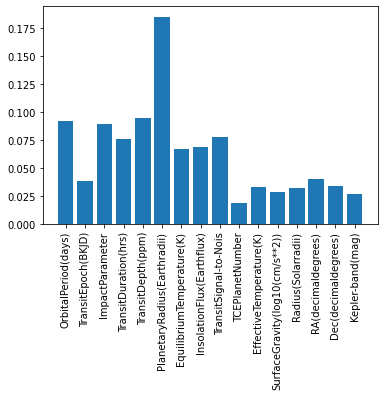

In [42]:
plt.bar(X_train.columns, best_forest.feature_importances_)
plt.xticks(rotation= 90)
plt.show()

It appears that Planetary Radius is the most important feature by some margin. The EDA I performed showed that confirmed and candidate exoplanets were in a much tighter range than the other KOIs, which ranged from very small to very large (relatively) objects.

I suspected that Transit Depth would play an important factor in the model through my EDA, and it is the 3rd most important predictor.

### Neural Network

Neural Networks got their name because they act like our brains, with neurons working in unison to solve different problems. They contain several layers usually:
- Input Layer(s) : This layer contains several nodes that receive raw data
- Hidden Layer(s) : These layers are where the work is done, more on this later
- Output Layer(s) : This is where the results are outputted
One single node/neuron takes in input from some other set of nodes (unless in the input layer) each associated with a specific weight. With all the input, a function is made from each input and fed to the next node (usually output layer)
![neuron](images/neuron.png)
The function is called an activation function, and its used to introduce non linearity to the output of the neuron. There are several activation functions such as sigmoid, tanh, and ReLU. I wont get into all of them but they basically transform the data in different ways.  
You may have noticed in the image there is a b term, this is bias. This is added so that each node has a trainable constant value. It essentially moves the resulting function around, without it all the resulting functions will pass through the origin.

Rather than just reword, I will refer you to [this medium post](https://purnasaigudikandula.medium.com/a-beginner-intro-to-neural-networks-543267bda3c8) as it describes all of the activation functions, and the processes of forward and backward propagation very well.

In [43]:
keras_tr = tf.convert_to_tensor(X_tr_scaled)
keras_tst = tf.convert_to_tensor(X_tst_scaled)

In [44]:
callbacks_list = ReduceLROnPlateau(monitor = "val_loss", factor = 0.2)

In [45]:
early_stop = EarlyStopping(monitor = 'loss', patience = 3)

In [46]:
model = Sequential()
model.add(Dense(120, input_dim = keras_tr.shape[1], activation='relu'))
model.add(Dense(120, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [47]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
history = model.fit(keras_tr, y_train, validation_data = [keras_tst, y_test], epochs=150, batch_size=10, callbacks = [early_stop])

Epoch 1/150
627/627 [==============================] - 2s 2ms/step - loss: 0.4753 - accuracy: 0.7839 - val_loss: 0.4240 - val_accuracy: 0.8029
Epoch 2/150
627/627 [==============================] - 1s 2ms/step - loss: 0.4148 - accuracy: 0.8115 - val_loss: 0.3912 - val_accuracy: 0.8215
Epoch 3/150
627/627 [==============================] - 1s 2ms/step - loss: 0.3962 - accuracy: 0.8190 - val_loss: 0.3816 - val_accuracy: 0.8249
Epoch 4/150
627/627 [==============================] - 1s 2ms/step - loss: 0.3810 - accuracy: 0.8310 - val_loss: 0.3936 - val_accuracy: 0.8197
Epoch 5/150
627/627 [==============================] - 1s 2ms/step - loss: 0.3709 - accuracy: 0.8356 - val_loss: 0.3815 - val_accuracy: 0.8200
Epoch 6/150
627/627 [==============================] - 1s 2ms/step - loss: 0.3673 - accuracy: 0.8355 - val_loss: 0.3702 - val_accuracy: 0.8316
Epoch 7/150
627/627 [==============================] - 1s 2ms/step - loss: 0.3597 - accuracy: 0.8416 - val_loss: 0.3714 - val_accuracy: 0.8282

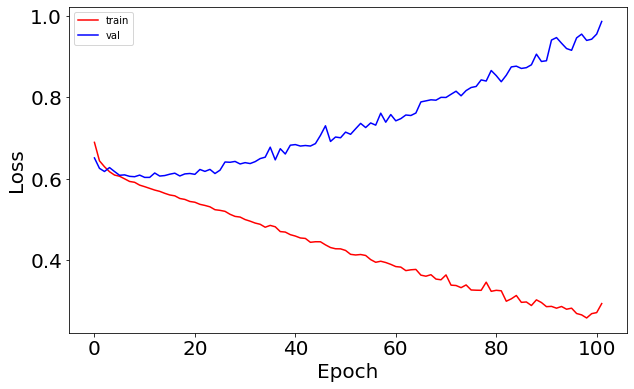

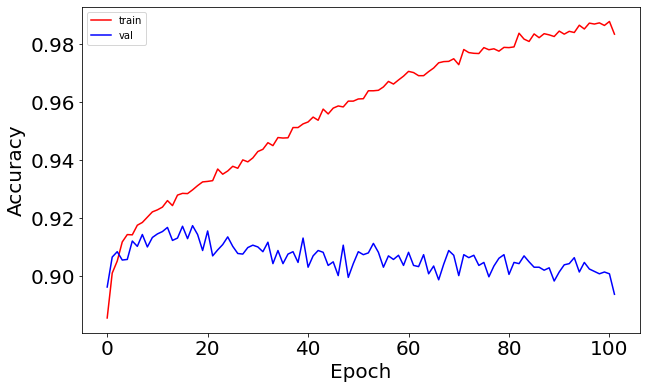

In [49]:

# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [50]:
scores = model.evaluate(X_tst_scaled, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

84/84 [==============================] - 0s 1ms/step - loss: 0.9739 - accuracy: 0.7984
accuracy: 79.84%


I tried several different versions of the neural network, and the accuracy remained around 80%, some further adjustments could definitely be performed, but I am happy with the performance of the random forest.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=eb883b55-1526-4482-aad8-9ba82b613495' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>